# (MBTI) Myers-Briggs Personality Type Prediction

* Extroversion vs. Introversion
    * I - 0
    * E - 1 
    
* Sensing vs. Intuition 
    * N - 0 
    * S - 1
    
* Thinking vs. Feeling
    * F - 0
    * T - 1
    
* Judging vs. Perceiving
    * P - 0
    * J - 1 
    
## MACHINE LEARNING - IMPLEMENTING & COMPARING DIFFERENT CLASSIFIERS  

In [7]:
# importing dependencies here
import numpy as np
import pandas as pd
import os

# visualizations
import matplotlib.pyplot as plt

# data stratifying and splitting
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer

# class imbalance
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler

# algorithms/models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from imblearn.metrics import classification_report_imbalanced
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

# performance check
import time
import warnings

warnings.filterwarnings("ignore")

# sparse to dense
from sklearn.base import TransformerMixin


class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


# saving the model
from joblib import dump

In [8]:
# reading the final dataset
path_to_csv = os.path.join("..", "data", "clean_data_3.csv")
personality_data = pd.read_csv(path_to_csv)

In [9]:
# checking top records
personality_data.head(2)

,type,is_Extrovert,is_Sensing,is_Thinking,is_Judging,posts,clean_posts,compound_sentiment,pos_sentiment,neg_sentiment,...,em,colons,emojis,word_count,unique_words,post_length_var,upper,link_count,ellipses,img_count
0,INTJ,0,0,1,1,"'Don’t peg your rate low, peg it high. An appe...",peg rate low peg high appeal expertise want...,0.99990,0.332011,0.098166,...,0.08,0.16,0.0,56.22,24.66,6718.126848,2.06,0.0,0.04,0.0
1,INTP,0,0,1,0,'...you get Kid Rock.|||Now it is. Plural: 2sh...,get kid rock plural shy happened skim ...,0.99995,0.312169,0.088457,...,0.20,2.04,0.0,136.48,48.64,15882.597104,6.98,0.0,0.34,0.0


### Setting predictors and target variable


In [10]:
# setting X to clean_posts, compound sentiment score, pos tags and various other counts
X = personality_data[
    [
        "clean_posts",
        "compound_sentiment",
        "ADJ_avg",
        "ADP_avg",
        "ADV_avg",
        "CONJ_avg",
        "DET_avg",
        "NOUN_avg",
        "NUM_avg",
        "PRT_avg",
        "PRON_avg",
        "VERB_avg",
        "qm",
        "em",
        "colons",
        "emojis",
        "word_count",
        "unique_words",
        "upper",
        "link_count",
        "ellipses",
        "img_count",
    ]
]

# setting y to four target classes -> is_Extrovert, is_Sensing, is_Thinking, is_Judging
y = personality_data.iloc[:, 1:5]

# ensuring that X and y row count matches
print(X.shape)
print(y.shape)

(3933, 22)
(3933, 4)


### Creating a list of words (other than the stop words) to be dropped to improve model performanace

In [11]:
additional_stopwords = [
    "hey",
    "hello",
    "briggs",
    "cat",
    "car",
    "mbti",
    "soup",
    "tea",
    "sport",
    "snow",
    "christmas",
]

### Setting up preprocessor for vectorization and selecting best counts and scores

In [12]:
# preprocessing steps for selecting best k columns/features from counts & scores and for vectorizing words

counts_n_scores = [
    "compound_sentiment",
    "ADJ_avg",
    "ADP_avg",
    "ADV_avg",
    "CONJ_avg",
    "DET_avg",
    "NOUN_avg",
    "NUM_avg",
    "PRT_avg",
    "PRON_avg",
    "VERB_avg",
    "qm",
    "em",
    "colons",
    "emojis",
    "word_count",
    "unique_words",
    "upper",
    "link_count",
    "ellipses",
    "img_count",
]

# for selecting k best features from features other than words
best_k_features = make_pipeline(MinMaxScaler(), SelectKBest(f_classif, k=10))

# setting up preprocessing for TF-IDF vectorizer
preprocesser_tf = ColumnTransformer(
    transformers=[
        (
            "tfidf",
            TfidfVectorizer(min_df=25, max_df=0.85, stop_words=additional_stopwords),
            "clean_posts",
        ),
        ("selectbest", best_k_features, counts_n_scores),
    ],
    remainder="passthrough",
)

# setting up preprocessing for COUNT vectorizer
preprocesser_ct = ColumnTransformer(
    transformers=[
        (
            "ct_vect",
            CountVectorizer(min_df=25, max_df=0.85, stop_words=additional_stopwords),
            "clean_posts",
        ),
        ("selectbest", best_k_features, counts_n_scores),
    ],
    remainder="passthrough",
)

### Modelling

In [13]:
# setting up the personality dictionary for printing scores for each class
mbti_type = {
    "is_Extrovert": "Extrovert vs Introvert",
    "is_Sensing": "Sensing vs Intuition",
    "is_Thinking": "Thinking vs Feeling",
    "is_Judging": "Judging vs Perceiving",
}

# function to build the model for predicting each of the 4 target classes
def build_model(model, X, target, vectorizer_name):

    for col in target.columns:

        print(f"\n{mbti_type[col]}")
        target = y[col]

        X_train, X_test, y_train, y_test = train_test_split(
            X, target, test_size=0.2, random_state=42, stratify=target
        )

        # model training
        model.fit(X_train, y_train)

        # y_hat
        y_pred = model.predict(X_test)

        # y_probability
        y_proba = model.predict_proba(X_test)[:, 1]

        # precision recall score
        average_precision = average_precision_score(y_test, y_proba)

        # model evaluation
        print(
            f"Geometric Mean Score: {geometric_mean_score(y_test, y_pred, average='weighted'):.2f}"
        )
        print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.2f}")
        print(f"Average Precision-Recall Score: {average_precision:.2f}")
        print(classification_report_imbalanced(y_test, y_pred))


### TF-IDF Logistic Regression

In [8]:
%%time

tfidf_logistic_regression = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV()
)
build_model(tfidf_logistic_regression, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.65
ROC-AUC Score: 0.68
Average Precision-Recall Score: 0.56
                   pre       rec       spe        f1       geo       iba       sup

          0       0.75      0.71      0.59      0.73      0.65      0.43       498
          1       0.54      0.59      0.71      0.57      0.65      0.42       289

avg / total       0.67      0.67      0.63      0.67      0.65      0.42       787


Sensing vs Intuition
Geometric Mean Score: 0.76
ROC-AUC Score: 0.82
Average Precision-Recall Score: 0.70
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.80      0.72      0.84      0.76      0.58       563
          1       0.59      0.72      0.80      0.65      0.76      0.57       224

avg / total       0.80      0.78      0.74      0.79      0.76      0.58       787


Thinking vs Feeling
Geometric Mean Score: 0.66
ROC-AUC Score: 0.72
Average Precision-Recall Score: 0.74
           

### Count Vectorized Logistic Regression

In [9]:
%%time
ct_logistic_regression = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV()
)
build_model(ct_logistic_regression, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.65
ROC-AUC Score: 0.70
Average Precision-Recall Score: 0.57
                   pre       rec       spe        f1       geo       iba       sup

          0       0.74      0.78      0.52      0.76      0.64      0.41       498
          1       0.58      0.52      0.78      0.55      0.64      0.39       289

avg / total       0.68      0.68      0.61      0.68      0.64      0.41       787


Sensing vs Intuition
Geometric Mean Score: 0.75
ROC-AUC Score: 0.80
Average Precision-Recall Score: 0.65
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.81      0.70      0.84      0.75      0.57       563
          1       0.59      0.70      0.81      0.64      0.75      0.56       224

avg / total       0.79      0.78      0.73      0.78      0.75      0.57       787


Thinking vs Feeling
Geometric Mean Score: 0.65
ROC-AUC Score: 0.70
Average Precision-Recall Score: 0.73
           

### TF-IDF Logistic Lasso

In [10]:
%%time
tfidf_logistic_regression_lasso = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV(penalty='l1', solver='saga' )
)
build_model(tfidf_logistic_regression_lasso, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.62
ROC-AUC Score: 0.68
Average Precision-Recall Score: 0.56
                   pre       rec       spe        f1       geo       iba       sup

          0       0.73      0.64      0.60      0.68      0.62      0.38       498
          1       0.49      0.60      0.64      0.54      0.62      0.38       289

avg / total       0.64      0.62      0.61      0.63      0.62      0.38       787


Sensing vs Intuition
Geometric Mean Score: 0.74
ROC-AUC Score: 0.82
Average Precision-Recall Score: 0.69
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.77      0.71      0.82      0.74      0.56       563
          1       0.56      0.71      0.77      0.63      0.74      0.55       224

avg / total       0.78      0.76      0.73      0.76      0.74      0.55       787


Thinking vs Feeling
Geometric Mean Score: 0.66
ROC-AUC Score: 0.71
Average Precision-Recall Score: 0.73
           

### Count Vectorized Logistic Lasso

In [11]:
%%time
ct_logistic_regression_lasso = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV(penalty='l1', solver='saga' )
)
build_model(ct_logistic_regression_lasso, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.52
ROC-AUC Score: 0.67
Average Precision-Recall Score: 0.53
                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.09      0.98      0.16      0.29      0.08       498
          1       0.38      0.98      0.09      0.55      0.29      0.09       289

avg / total       0.68      0.41      0.65      0.30      0.29      0.08       787


Sensing vs Intuition
Geometric Mean Score: 0.46
ROC-AUC Score: 0.74
Average Precision-Recall Score: 0.55
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.01      1.00      0.01      0.08      0.01       563
          1       0.29      1.00      0.01      0.44      0.08      0.01       224

avg / total       0.80      0.29      0.72      0.14      0.08      0.01       787


Thinking vs Feeling
Geometric Mean Score: 0.60
ROC-AUC Score: 0.68
Average Precision-Recall Score: 0.70
           

### TF-IDF Logistic Ridge

In [12]:
%%time
tfidf_logistic_regression_ridge = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV(penalty='l2', solver='saga' )
)
build_model(tfidf_logistic_regression_ridge, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.66
ROC-AUC Score: 0.70
Average Precision-Recall Score: 0.59
                   pre       rec       spe        f1       geo       iba       sup

          0       0.77      0.68      0.64      0.72      0.66      0.44       498
          1       0.54      0.64      0.68      0.58      0.66      0.43       289

avg / total       0.68      0.67      0.66      0.67      0.66      0.44       787


Sensing vs Intuition
Geometric Mean Score: 0.76
ROC-AUC Score: 0.83
Average Precision-Recall Score: 0.69
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.78      0.75      0.83      0.76      0.59       563
          1       0.58      0.75      0.78      0.65      0.76      0.58       224

avg / total       0.80      0.77      0.76      0.78      0.76      0.59       787


Thinking vs Feeling
Geometric Mean Score: 0.66
ROC-AUC Score: 0.72
Average Precision-Recall Score: 0.74
           

### Count Vectorized Logistic Ridge

In [13]:
%%time
ct_logistic_regression_ridge = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV(penalty='l2', solver='saga' )
)
build_model(ct_logistic_regression_ridge, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.52
ROC-AUC Score: 0.68
Average Precision-Recall Score: 0.55
                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.09      0.97      0.16      0.29      0.08       498
          1       0.38      0.97      0.09      0.55      0.29      0.09       289

avg / total       0.68      0.41      0.65      0.30      0.29      0.08       787


Sensing vs Intuition
Geometric Mean Score: 0.45
ROC-AUC Score: 0.74
Average Precision-Recall Score: 0.57
                   pre       rec       spe        f1       geo       iba       sup

          0       0.70      0.01      0.99      0.02      0.11      0.01       563
          1       0.28      0.99      0.01      0.44      0.11      0.01       224

avg / total       0.58      0.29      0.71      0.14      0.11      0.01       787


Thinking vs Feeling
Geometric Mean Score: 0.63
ROC-AUC Score: 0.69
Average Precision-Recall Score: 0.70
           

### TF-IDF Logistic Elasticnet

* Takes longest to run and the results are almost same as lasso and ridge model. So this code is commented to save time when re-running the entire notebook.

In [14]:
%%time
from sklearn.metrics import classification_report

for col in y.columns:

    print(f"\n{mbti_type[col]}")

    target = y[col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, target, test_size=0.2, random_state=42, stratify=target
    )

    tfidf_logistic_regression_elasticnet = imb_make_pipeline(
        preprocesser_tf,
    #     DenseTransformer(),
        RandomUnderSampler(),
        LogisticRegressionCV(
            penalty='elasticnet',
            l1_ratios=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
            solver='saga'
        )
    )

    tfidf_logistic_regression_elasticnet.fit(X_train, y_train)

    print(f'Accuracy: {tfidf_logistic_regression_elasticnet.score(X_test, y_test)} \n')
    print(classification_report(y_test, tfidf_logistic_regression_elasticnet.predict(X_test)))


Extrovert vs Introvert
Accuracy: 0.6378653113087674 

              precision    recall  f1-score   support

           0       0.74      0.66      0.70       498
           1       0.51      0.60      0.55       289

    accuracy                           0.64       787
   macro avg       0.62      0.63      0.62       787
weighted avg       0.65      0.64      0.64       787


Sensing vs Intuition
Accuracy: 0.7674714104193139 

              precision    recall  f1-score   support

           0       0.89      0.77      0.83       563
           1       0.57      0.76      0.65       224

    accuracy                           0.77       787
   macro avg       0.73      0.76      0.74       787
weighted avg       0.80      0.77      0.78       787


Thinking vs Feeling
Accuracy: 0.6734434561626429 

              precision    recall  f1-score   support

           0       0.62      0.62      0.62       336
           1       0.72      0.71      0.71       451

    accuracy          

### TF-IDF Support Vector Classifier

In [15]:
%%time
tfidf_svc = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), DenseTransformer(), SVC(kernel='linear',probability=True)
)
build_model(tfidf_svc, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.64
ROC-AUC Score: 0.70
Average Precision-Recall Score: 0.60
                   pre       rec       spe        f1       geo       iba       sup

          0       0.75      0.65      0.64      0.70      0.64      0.41       498
          1       0.51      0.64      0.65      0.57      0.64      0.41       289

avg / total       0.67      0.64      0.64      0.65      0.64      0.41       787


Sensing vs Intuition
Geometric Mean Score: 0.78
ROC-AUC Score: 0.82
Average Precision-Recall Score: 0.70
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.80      0.76      0.84      0.78      0.61       563
          1       0.60      0.76      0.80      0.67      0.78      0.60       224

avg / total       0.81      0.79      0.77      0.79      0.78      0.60       787


Thinking vs Feeling
Geometric Mean Score: 0.67
ROC-AUC Score: 0.73
Average Precision-Recall Score: 0.75
           

### Count Vectorized Support Vector Classifier

In [14]:
%%time
ct_svc = imb_make_pipeline(
    preprocesser_ct, DenseTransformer(), RandomUnderSampler(), SVC(kernel='linear',probability=True)
)
build_model(ct_svc, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.58
ROC-AUC Score: 0.51
Average Precision-Recall Score: 0.38
                   pre       rec       spe        f1       geo       iba       sup

          0       0.71      0.56      0.61      0.63      0.58      0.34       498
          1       0.44      0.61      0.56      0.51      0.58      0.34       289

avg / total       0.61      0.58      0.59      0.58      0.58      0.34       787


Sensing vs Intuition
Geometric Mean Score: 0.56
ROC-AUC Score: 0.56
Average Precision-Recall Score: 0.36
                   pre       rec       spe        f1       geo       iba       sup

          0       0.76      0.57      0.55      0.65      0.56      0.31       563
          1       0.34      0.55      0.57      0.42      0.56      0.31       224

avg / total       0.64      0.56      0.55      0.58      0.56      0.31       787


Thinking vs Feeling
Geometric Mean Score: 0.60
ROC-AUC Score: 0.64
Average Precision-Recall Score: 0.68
           

### TF-IDF Naive Bayes

In [15]:
%%time
tfidf_nb = imb_make_pipeline(
    preprocesser_tf, DenseTransformer(), RandomUnderSampler(), MultinomialNB(),
)
build_model(tfidf_nb, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.55
ROC-AUC Score: 0.62
Average Precision-Recall Score: 0.50
                   pre       rec       spe        f1       geo       iba       sup

          0       0.72      0.30      0.81      0.42      0.49      0.23       498
          1       0.40      0.81      0.30      0.53      0.49      0.25       289

avg / total       0.60      0.48      0.62      0.46      0.49      0.23       787


Sensing vs Intuition
Geometric Mean Score: 0.52
ROC-AUC Score: 0.69
Average Precision-Recall Score: 0.54
                   pre       rec       spe        f1       geo       iba       sup

          0       0.82      0.20      0.89      0.32      0.42      0.17       563
          1       0.31      0.89      0.20      0.46      0.42      0.19       224

avg / total       0.67      0.40      0.69      0.36      0.42      0.17       787


Thinking vs Feeling
Geometric Mean Score: 0.64
ROC-AUC Score: 0.70
Average Precision-Recall Score: 0.71
           

### Count Vectorized Naive Bayes

In [16]:
%%time
ct_nb = imb_make_pipeline(
    preprocesser_ct, DenseTransformer(), RandomUnderSampler(), MultinomialNB(),
)
build_model(ct_nb, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.55
ROC-AUC Score: 0.59
Average Precision-Recall Score: 0.48
                   pre       rec       spe        f1       geo       iba       sup

          0       0.69      0.48      0.63      0.57      0.55      0.30       498
          1       0.41      0.63      0.48      0.50      0.55      0.31       289

avg / total       0.59      0.53      0.57      0.54      0.55      0.30       787


Sensing vs Intuition
Geometric Mean Score: 0.57
ROC-AUC Score: 0.60
Average Precision-Recall Score: 0.41
                   pre       rec       spe        f1       geo       iba       sup

          0       0.78      0.48      0.66      0.60      0.56      0.31       563
          1       0.34      0.66      0.48      0.44      0.56      0.32       224

avg / total       0.65      0.53      0.61      0.55      0.56      0.32       787


Thinking vs Feeling
Geometric Mean Score: 0.61
ROC-AUC Score: 0.67
Average Precision-Recall Score: 0.70
           

### TF-IDF Random Forest

In [17]:
%%time
tfidf_rf = imb_make_pipeline(
    preprocesser_tf, DenseTransformer(),
        RandomUnderSampler(),
        RandomForestClassifier(n_estimators=100, max_depth=10),
)
build_model(tfidf_rf, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.63
ROC-AUC Score: 0.67
Average Precision-Recall Score: 0.55
                   pre       rec       spe        f1       geo       iba       sup

          0       0.73      0.69      0.56      0.71      0.63      0.40       498
          1       0.52      0.56      0.69      0.54      0.63      0.39       289

avg / total       0.65      0.65      0.61      0.65      0.63      0.39       787


Sensing vs Intuition
Geometric Mean Score: 0.69
ROC-AUC Score: 0.75
Average Precision-Recall Score: 0.57
                   pre       rec       spe        f1       geo       iba       sup

          0       0.83      0.79      0.59      0.81      0.68      0.48       563
          1       0.53      0.59      0.79      0.56      0.68      0.46       224

avg / total       0.74      0.73      0.65      0.74      0.68      0.47       787


Thinking vs Feeling
Geometric Mean Score: 0.63
ROC-AUC Score: 0.69
Average Precision-Recall Score: 0.71
           

### Count Vectorized Random Forest

In [18]:
%%time
ct_rf = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), RandomForestClassifier(n_estimators=100, max_depth=10),
)
build_model(ct_rf, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.62
ROC-AUC Score: 0.67
Average Precision-Recall Score: 0.55
                   pre       rec       spe        f1       geo       iba       sup

          0       0.73      0.69      0.55      0.71      0.62      0.39       498
          1       0.51      0.55      0.69      0.53      0.62      0.38       289

avg / total       0.65      0.64      0.61      0.65      0.62      0.39       787


Sensing vs Intuition
Geometric Mean Score: 0.71
ROC-AUC Score: 0.74
Average Precision-Recall Score: 0.54
                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.79      0.64      0.82      0.71      0.51       563
          1       0.55      0.64      0.79      0.59      0.71      0.50       224

avg / total       0.76      0.75      0.68      0.75      0.71      0.51       787


Thinking vs Feeling
Geometric Mean Score: 0.62
ROC-AUC Score: 0.67
Average Precision-Recall Score: 0.70
           

### Final Model - Logistic Regression with TF-IDF Vectorization

Selecting TF-IDF Logistic Regression as our final model as it returned the highest scores for all metrics - accuracy, precision, recall, roc-auc, avg_precision_recall as compared to other models.


Extrovert vs Introvert
               coef
word               
love       2.309715
boyfriend  2.104251
advice     2.093980
extrovert  2.014531
crazy      1.979860
friend     1.910236
dude       1.902429
test       1.893324
debate     1.883466
super      1.874069
autism    -1.871727
watched   -1.857955
rly        1.839819
por        1.791624
big        1.791424
adhd       1.779850
autistic  -1.776870
helped     1.747866
deck      -1.739351
enneagram  1.721543
thought   -1.719695

Sensing vs Intuition
               coef
word               
human     -2.404140
world     -2.382216
thanks     2.354161
yeah       2.240944
anyone    -2.227895
adhd      -2.096479
intuitive  2.019469
pretty     1.971774
romantic  -1.882825
guy       -1.829289
music      1.802845
fun        1.708477
create    -1.697773
love      -1.654712
relate     1.633772
boring     1.629247
depends    1.621722
quiet      1.600155
data       1.592675
hobby      1.580236
stuck      1.571460

Thinking vs Feeling
             

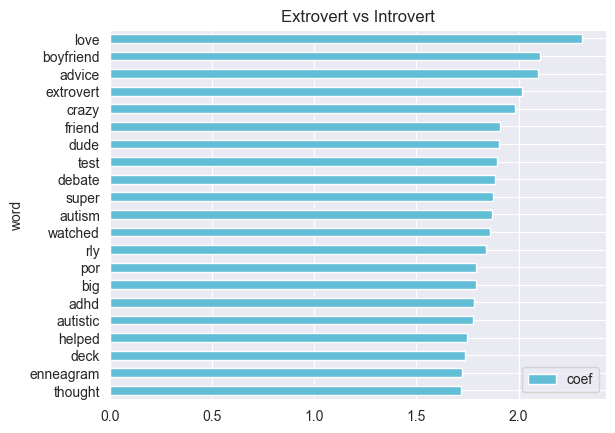

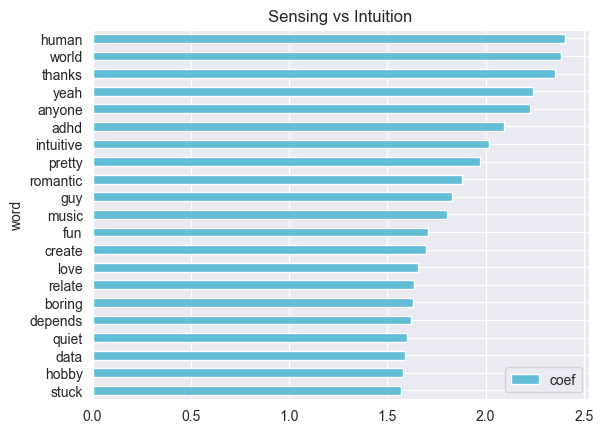

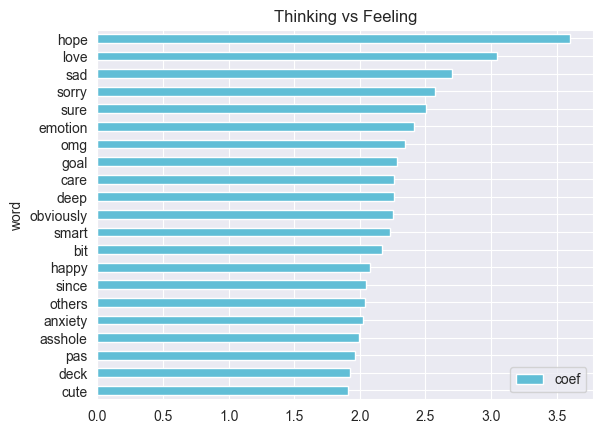

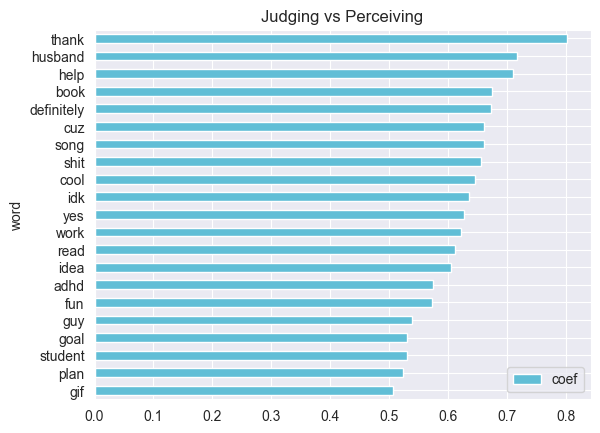

In [19]:
%%time

for col in y.columns:
    
    print(f"\n{mbti_type[col]}")

    target = y[col]

    tfidf_logistic_regression = imb_make_pipeline(
        preprocesser_tf,
        RandomUnderSampler(),
        LogisticRegressionCV()
    )
    
    # training the data on entire dataset
    tfidf_logistic_regression.fit(X, target)
    
    # feature importance   
    coef = tfidf_logistic_regression[-1].coef_[0]  
    word = tfidf_logistic_regression[0].named_transformers_["tfidf"].get_feature_names()
    word_list = list(zip(word, coef))         
    result = pd.DataFrame(word_list, columns=["word", "coef"]).set_index("word")    
    result = result.reindex(result.coef.abs().sort_values(ascending=False).index)[0:21]
    print(result)
    
    # plotting feature importance
    result["coef"] = result["coef"].apply(lambda x: abs(x))
    result.sort_values("coef", inplace=True)
    result.plot(kind="barh", color="#61BED6", title=mbti_type[col])
  
    # saving the model
    dump(tfidf_logistic_regression, f"clf_{col}.joblib")